In [1]:
import numpy as np
import torch
import random
import copy
import matplotlib.pyplot as plt

In [2]:
from load_data import *

In [3]:
from generate_data import *

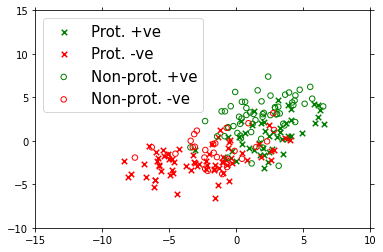

In [31]:
X_tr,X_te,y_tr,y_te,xs_tr,xs_te = load_sythetic_data(svm=True,plot_data=True,n_samples = 1000,disc_factor = math.pi / 4.0)

In [32]:
from sklearn import linear_model as lm

In [34]:
idx_yns0 = (y_te.flatten()==-1)*(xs_te.flatten()==0)

In [35]:
def plot_fig_fair(X,y,xs,clf, **params):
    X0,X1 = X[:,0],X[:,1]
    
    xx, yy = make_meshgrid(X0, X1)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    y = y.flatten()
    xs = xs.flatten()
    
    idx_yps0 = (y==1)*(xs==0)
    idx_yps1 = (y==1)*(xs==1)
    idx_yns0 = (y==-1)*(xs==0)
    idx_yns1 = (y==-1)*(xs==1)
    
    plt.figure()
    plt.contourf(xx, yy,Z,cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(X0[idx_yns0], X1[idx_yns0], color='yellow', marker = 'x', label='negative 0')
    plt.scatter(X0[idx_yns1], X1[idx_yns1], color='yellow',facecolors='none', marker = 'o', label='negative 1')
    plt.scatter(X0[idx_yps0], X1[idx_yps0], color='green', marker = 'x', label='positive 0')
    plt.scatter(X0[idx_yps1], X1[idx_yps1], color='green',facecolors='none', marker = 'o', label='positive 1')
    
    plt.legend()
    plt.show()

In [36]:
clf2 = lm.LogisticRegression()
clf2.fit(X_tr,y_tr)

LogisticRegression()

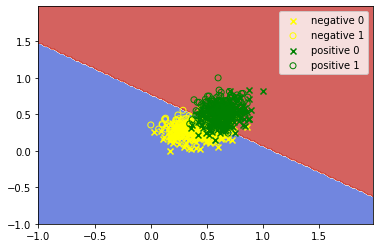

In [37]:
plot_fig_fair(X_tr,y_tr,xs_tr,clf2)

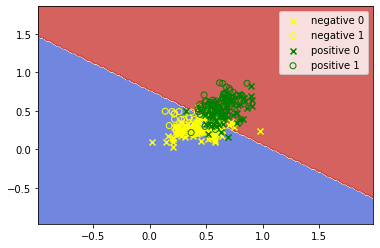

In [38]:
plot_fig_fair(X_te,y_te,xs_te,clf2)

In [184]:
print(sum(xs_te==1)/sum(xs_te==0))

[0.8404908]


# Poisoning attacks

In [39]:
def shuffle_array(arr_list, sample_ratio = 0.9, rs = 3):
    n_sam = int(len(arr_list[0])*sample_ratio)
    random.seed(rs)
    r_idxs = list(range(len(arr_list[0])))
    random.shuffle(r_idxs)
    arr_t = []
    for arr in arr_list:
        arr_t.append(copy.deepcopy(arr)[r_idxs][:n_sam])
    return tuple(arr_t)

In [40]:
xx,yy,zz = shuffle_array([X_tr,y_tr,xs_tr])

In [41]:
def poison_Z(xs,pos_rt = 0.1, rs = 3):
    n_pos = int(len(xs)*pos_rt)
    random.seed(rs)
    r_idxs = list(range(len(xs)))
    random.shuffle(r_idxs)
    xsp = copy.deepcopy(xs)
    xsp[r_idxs[:n_pos]] = 1-xs_tr[r_idxs[:n_pos]]
    return xsp

In [42]:
from fairLR_train import *

In [43]:
xs_tep =  poison_Z(xs_te,pos_rt = 0.1, rs = 3)

# Evaluation Results

In [45]:
from fairLR_test import *
from save_utils import load_flr, load_nparray,save_prediction
from fair_eval import *

In [46]:
def add_res(res,res_sum):
    for ikey in res:
        if ikey == 'odds':
            for jkey in res[ikey]:
                res_sum[ikey][jkey] +=  res[ikey][jkey]
        else:
            res_sum[ikey] += res[ikey]
    return res_sum
def divide_res(res_sum, rep = 5):
    for ikey in res_sum:
        if ikey =='odds':
            for jkey in res_sum[ikey]:
                    res_sum[ikey][jkey] /=  rep
        else:
            res_sum[ikey] /= rep
    return res_sum
def print_res(res):
    for ikey in res:
        print(ikey,": ",res[ikey])

In [186]:
def test_LR_avg(clf,X_te, y_te,xs_te):
    pred = clf.predict(X_te)
    pred = pred.flatten()
    y_te = y_te.flatten()
    xs_te = xs_te.flatten()
    res = {}
    res['accuary'] = calculate_overall_accuracy(pred,y_te,True)
    res['dispImp'] = calculate_impact(pred,y_te,xs_te)
    res['dispMisclf'] = calculate_misclassification(pred,y_te,xs_te)
    res['dispFPR'] = calculate_mistreatment(pred,y_te,xs_te,cond=-1)
    res['dispFNR'] = calculate_mistreatment(pred,y_te,xs_te,cond=1)
    res['odds'] = calculate_odds_clf(pred,y_te,xs_te,return_val = True)
    return res

def test_LR_avg_diff(clf,X_te, y_te,xs_te):
    pred = clf.predict(X_te)
    pred = pred.flatten()
    y_te = y_te.flatten()
    xs_te = xs_te.flatten()
    res = {}
    res['accuary'] = calculate_overall_accuracy(pred,y_te,True)
    res['dispImp'] = diff_calculate_impact(pred,y_te,xs_te)
    res['dispMisclf'] = diff_calculate_misclassification(pred,y_te,xs_te)
    res['dispFPR'] = diff_calculate_mistreatment(pred,y_te,xs_te,cond=-1)
    res['dispFNR'] = diff_calculate_mistreatment(pred,y_te,xs_te,cond=1)
    res['odds'] = diff_calculate_odds_clf(pred,y_te,xs_te,return_val = True)
    return res

In [48]:
def test_LR(clf,X_te, y_te,xs_te):
    pred = clf.predict(X_te)
    calculate_overall_accuracy(pred,y_te)
    calculate_prule_clf(pred,y_te,xs_te)
    calculate_odds_clf(pred,y_te,xs_te)

In [127]:
def calculate_gamma(alpha, beta):
    gamma = 2*alpha/(beta*(1-alpha)+alpha)
    return gamma

def calculate_thm(empg, alpha, beta, epsilon, delta=0.05,z_num = 2):
    gamma = calculate_gamma(alpha,beta)
    assert epsilon >2*gamma
    mz = (2/(epsilon-2*gamma-empg)**2)*np.log(2*z_num/delta)
    return mz
    

In [153]:
np.log(2*z_num/delta)

4.382026634673881

In [128]:
alpha = 0.01
beta = 1.0
epsilon = 0.1
delta = 0.05
z_num = 2
####empirical#####
empg = 0.015
print(calculate_gamma(alpha, beta))
print(calculate_thm(empg,alpha,beta, epsilon,delta,z_num))

0.02
4327.927540418647


In [73]:
from matplotlib import pyplot as plt

In [114]:
gamma = calculate_gamma(alpha, beta, epsilon)
print(epsilon-2*gamma)
empgs = list(np.arange(0.00,epsilon-2*gamma,0.001))

0.060000000000000005


In [115]:
print(2*gamma,epsilon)

0.04 0.1


In [109]:
func =  lambda a: calculate_thm(a,alpha,beta,epsilon,delta,z_num)

In [116]:
# print(empgs)
# res = list(map(np.log,list(map(func,empgs))))
res = list(map(lambda a: a/10**4,list(map(func,empgs))))

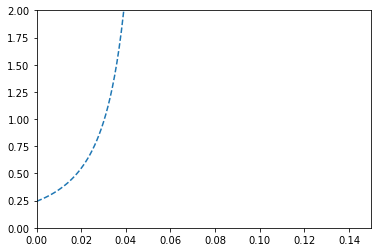

In [120]:
plt.plot(empgs,res,linestyle='--')
plt.axis([0,0.15,0,2])
plt.show()

In [202]:
import itertools
alphas = [0,0.005,0.01,0.05]
betas = [1.0,0.75]
epsilons = [0.05,0.075,0.1,0.15]
abe = itertools.product(alphas,betas,epsilons)
print(abe)
for i,(a,b,e) in enumerate(abe):
    if 2*calculate_gamma(a,b)<e:
        print(i)
        print(a,',',b,',',e)
    else:
        print(2*calculate_gamma(a,b),e)

0
0 , 1.0 , 0.05
1
0 , 1.0 , 0.075
2
0 , 1.0 , 0.1
3
0 , 1.0 , 0.15
4
0 , 0.75 , 0.05
5
0 , 0.75 , 0.075
6
0 , 0.75 , 0.1
7
0 , 0.75 , 0.15
8
0.005 , 1.0 , 0.05
9
0.005 , 1.0 , 0.075
10
0.005 , 1.0 , 0.1
11
0.005 , 1.0 , 0.15
12
0.005 , 0.75 , 0.05
13
0.005 , 0.75 , 0.075
14
0.005 , 0.75 , 0.1
15
0.005 , 0.75 , 0.15
16
0.01 , 1.0 , 0.05
17
0.01 , 1.0 , 0.075
18
0.01 , 1.0 , 0.1
19
0.01 , 1.0 , 0.15
0.053156146179402 0.05
21
0.01 , 0.75 , 0.075
22
0.01 , 0.75 , 0.1
23
0.01 , 0.75 , 0.15
0.2 0.05
0.2 0.075
0.2 0.1
0.2 0.15
0.26229508196721313 0.05
0.26229508196721313 0.075
0.26229508196721313 0.1
0.26229508196721313 0.15


In [197]:
abes = [(0.005, 0.75, 0.05),(0.01, 1.0, 0.075),(0.01, 0.75, 0.1),(0.005, 1.0, 0.075),(0.01, 1.0, 0.1),(0 , 0.75 , 0.05),(0 , 0.75 , 0.075)]

In [198]:
lb = "a: %f, b:%f, e:%f"%(a,b,e)
print(lb)

a: 0.000000, b:0.750000, e:0.050000


0.005 0.75 0.05
0.023377703826955077
0.01 1.0 0.075
0.034999999999999996
0.01 0.75 0.1
0.046843853820598004
0.005 1.0 0.075
0.05499999999999999
0.01 1.0 0.1
0.060000000000000005
0 0.75 0.05
0.05
0 0.75 0.075
0.075


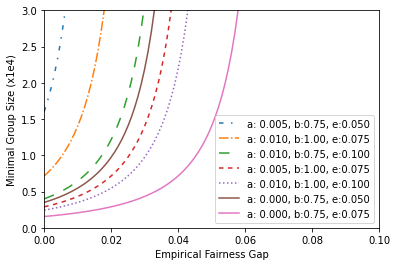

In [229]:
abes = [(0.005, 0.75, 0.05),(0.01, 1.0, 0.075),(0.01, 0.75, 0.1),(0.005, 1.0, 0.075),(0.01, 1.0, 0.1),(0 , 0.75 , 0.05),(0 , 0.75 , 0.075)]
delta = 0.05
z_num = 2
lnst = [ (0, (3, 5, 1, 5)),'-.',(0, (7,7)),(0, (3,3)),':','-','-']

for i,(a,b,e) in enumerate(abes):
    print(a,b,e)
    gamma = calculate_gamma(a,b)
    print(e-2*gamma)
    func =  lambda x: calculate_thm(x,a,b,e,delta,z_num)
    empgs = list(np.arange(0.00,e-2*gamma,0.001))
    res = list(map(lambda x: x/10**4,list(map(func,empgs))))
    lb = "a: %.3f, b:%.2f, e:%.3f"%(a,b,e)
    plt.plot(empgs,res,linestyle=lnst[i],label=lb)
plt.legend()
plt.axis([0,0.1,0,3.0])
plt.xlabel("Empirical Fairness Gap")
plt.ylabel("Minimal Group Size (x1e4)")
plt.show()

In [ ]:
abes = [(0.005, 0.75, 0.05),(0.01, 1.0, 0.075),(0.01, 0.75, 0.1),(0.005, 1.0, 0.075),(0.01, 1.0, 0.1),(0 , 0.75 , 0.05),(0 , 0.75 , 0.075)]

In [207]:
## adult
beta = 0.47659991
gm0 = calculate_gamma(0,beta)
gm1 = calculate_gamma(0.005,beta)
gm2 = calculate_gamma(0.01,beta)

epsilon = 0.1
print(-2*gm0+epsilon,-2*gm1+epsilon,-2*gm2+epsilon)
empgs = [0.090709,0.0893753,0.088693957]
alps = [0,0.005,0.01]
print(calculate_thm(empgs[0], alps[0], beta, epsilon, delta=0.05,z_num = 2))
print(calculate_thm(empgs[1], alps[1], beta, epsilon, delta=0.05,z_num = 2))
print(calculate_thm(empgs[2], alps[2], beta, epsilon, delta=0.05,z_num = 2))

0.1 0.05826524572928915 0.016983842159873183
101526.65751134105
9055.313098244398
1704.292656114959


0.0 0.47659991 0.1
0.1
0.005 0.47659991 0.1
0.05826524572928915
0.01 0.47659991 0.1
0.016983842159873183


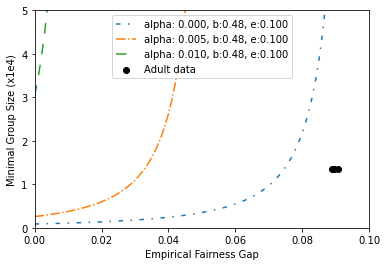

In [230]:
## adult
beta = 0.47659991
abes = [(0.0, beta, 0.1),(0.005, beta, 0.1),(0.01, beta, 0.1)]
delta = 0.05
z_num = 2
lnst = [ (0, (3, 5, 1, 5)),'-.',(0, (7,7)),(0, (3,3)),':','-','-']

for i,(a,b,e) in enumerate(abes):
    print(a,b,e)
    gamma = calculate_gamma(a,b)
    print(e-2*gamma)
    func =  lambda x: calculate_thm(x,a,b,e,delta,z_num)
    empgs = list(np.arange(0.00,e-2*gamma,0.001))
    res = list(map(lambda x: x/10**4,list(map(func,empgs))))
    lb = "alpha: %.3f, b:%.2f, e:%.3f"%(a,b,e)
    plt.plot(empgs,res,linestyle=lnst[i],label=lb)
plt.scatter([0.090709],[13567/10000],color = 'k',marker='o',label='Adult data')
plt.scatter([0.0893753],[13567/10000],color = 'k',marker='o')
plt.scatter([0.088693957],[13567/10000],color = 'k',marker='o')
plt.legend()
plt.axis([0,0.1,0,5.0])
plt.xlabel("Empirical Fairness Gap")
plt.ylabel("Minimal Group Size (x1e4)")
plt.show()

0.0 0.67415453 0.1
0.1
0.005 0.67415453 0.1
0.07040473408472046
0.01 0.67415453 0.1
0.04095182569062438


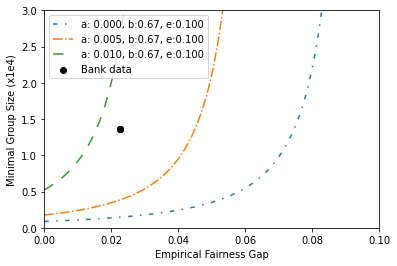

In [231]:
## bank
beta = 0.67415453
abes = [(0.0, beta, 0.1),(0.005, beta, 0.1),(0.01, beta, 0.1)]
delta = 0.05
z_num = 2
lnst = [ (0, (3, 5, 1, 5)),'-.',(0, (7,7)),(0, (3,3)),':','-','-']

for i,(a,b,e) in enumerate(abes):
    print(a,b,e)
    gamma = calculate_gamma(a,b)
    print(e-2*gamma)
    func =  lambda x: calculate_thm(x,a,b,e,delta,z_num)
    empgs = list(np.arange(0.00,e-2*gamma,0.001))
    res = list(map(lambda x: x/10**4,list(map(func,empgs))))
    lb = "a: %.3f, b:%.2f, e:%.3f"%(a,b,e)
    plt.plot(empgs,res,linestyle=lnst[i],label=lb)
plt.scatter([0.022550453],[13564/10000],color = 'k',marker='o',label='Bank data')
plt.scatter([0.0225997514812544],[13564/10000],color = 'k',marker='o')
plt.scatter([0.022494368360459718],[13564/10000],color = 'k',marker='o')
plt.legend()
plt.axis([0,0.1,0,3.0])
plt.xlabel("Empirical Fairness Gap")
plt.ylabel("Minimal Group Size (x1e4)")
plt.show()

In [208]:
## bank
beta = 0.67415453
gm0 = calculate_gamma(0,beta)
gm1 = calculate_gamma(0.005,beta)
gm2 = calculate_gamma(0.01,beta)

epsilon = 0.1
print(-2*gm0+epsilon,-2*gm1+epsilon,-2*gm2+epsilon)
empgs = [0.022550453,0.0225997514812544,0.022494368360459718]
alps = [0,0.005,0.01]
print(calculate_thm(empgs[0], alps[0], beta, epsilon, delta=0.05,z_num = 2))
print(calculate_thm(empgs[1], alps[1], beta, epsilon, delta=0.05,z_num = 2))
print(calculate_thm(empgs[2], alps[2], beta, epsilon, delta=0.05,z_num = 2))

0.1 0.07040473408472046 0.04095182569062438
1461.0572873812218
3834.940936912783
25725.348238003065


In [ ]:
import intertools
alphas = [0.01,0.05]
betas = [1.0,0.75]
epsilons = [0.1,0.05]
abe = itertools(alphas,betas,epsilons)
delta = 0.05
z_num = 2


gamma = calculate_gamma(alpha, beta, epsilon)
print(epsilon-2*gamma)
empgs = list(np.arange(0.00,epsilon-2*gamma,0.001))

plt.plot(empgs,res,linestyle='--')
plt.axis([0,0.15,0,2])
plt.show()

300
poisoned ratio:  0.0


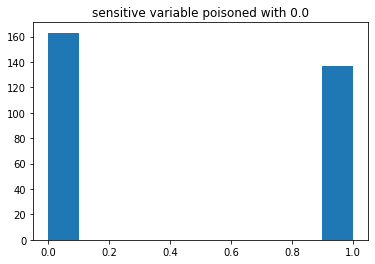

accuary :  87.66666666666666
dispImp :  42.053647395996606
dispMisclf :  2.548027405848372
dispFPR :  14.830214830214828
dispFNR :  14.128728414442701
odds :  {-1.0: 14.830214830214828, 1.0: 14.128728414442705}
poisoned ratio:  0.01


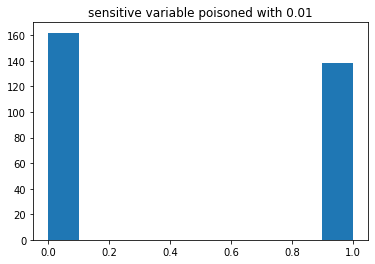

accuary :  87.66666666666666
dispImp :  41.48681459307708
dispMisclf :  2.3447868293886214
dispFPR :  14.924416454739381
dispFNR :  13.962551189883285
odds :  {-1.0: 14.924416454739381, 1.0: 13.962551189883282}
poisoned ratio:  0.05


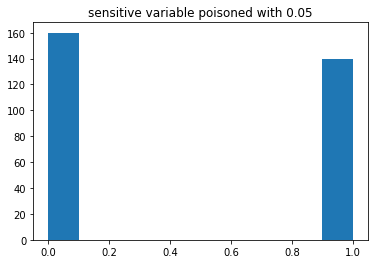

accuary :  87.66666666666666
dispImp :  39.67406304144935
dispMisclf :  2.5168719287907826
dispFPR :  13.524258937320814
dispFNR :  13.33089231765897
odds :  {-1.0: 13.524258937320814, 1.0: 13.330892317658968}
poisoned ratio:  0.1


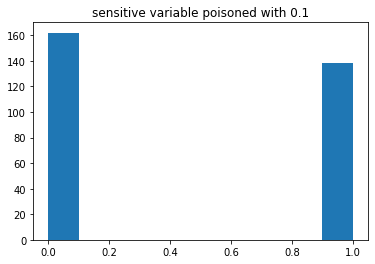

accuary :  87.66666666666666
dispImp :  37.101883572794605
dispMisclf :  2.5793877240922134
dispFPR :  12.254068229863536
dispFNR :  12.427146339201595
odds :  {-1.0: 12.254068229863536, 1.0: 12.427146339201595}
poisoned ratio:  0.2


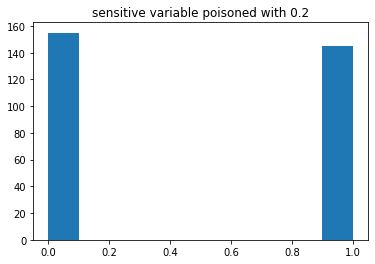

accuary :  87.66666666666666
dispImp :  32.6472423582674
dispMisclf :  2.9411195679990842
dispFPR :  8.839023788658048
dispFNR :  11.411419655794402
odds :  {-1.0: 8.839023788658048, 1.0: 11.411419655794406}
poisoned ratio:  0.3


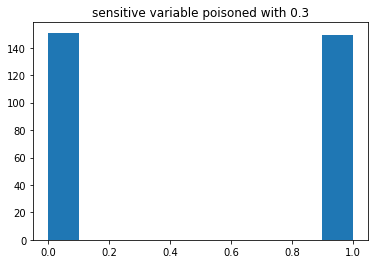

accuary :  87.66666666666666
dispImp :  26.637334479158277
dispMisclf :  3.474445627238107
dispFPR :  6.157177690995301
dispFNR :  10.004605579567492
odds :  {-1.0: 6.157177690995301, 1.0: 10.004605579567492}


In [187]:
print(len(xs_te))
rep = 10
ress = []
for rt in [0.0,0.01,0.05,0.1,0.2,0.3]:
    print("="*20)
    print("poisoned ratio: ", rt)
    print("="*20)
    for j in range(rep):
        xs_tep =  poison_Z(xs_te,pos_rt =rt, rs = 3*j)
        res = test_LR_avg_diff(clf2,X_te, y_te,xs_tep)
        if j==0:
            res_sum = res
        else:
            res_sum = add_res(res, res_sum)
    res_sum = divide_res(res_sum,rep)
    ress.append(res_sum)
    plt.figure()
    plt.title('sensitive variable poisoned with '+str(rt))
    plt.hist(xs_tep.flatten())
    plt.show()
    print_res(res_sum)
#     test_FLR(X_te,y_te,xs_tep,load_path = '../results/german_FLR_model.sm')

In [50]:
print(res_sum)

{'accuary': 87.66666666666666, 'dispImp': 59.73812149346564, 'dsipMisclf': 76.19190642998976, 'dispFPR': 68.55290275289099, 'dispFNR': 38.986272902062076, 'odds': {-1.0: 68.55290275289099, 1.0: 89.34903045719393}}


In [188]:
ress

[{'accuary': 87.66666666666666,
  'dispImp': 42.053647395996606,
  'dispMisclf': 2.548027405848372,
  'dispFPR': 14.830214830214828,
  'dispFNR': 14.128728414442701,
  'odds': {-1.0: 14.830214830214828, 1.0: 14.128728414442705}},
 {'accuary': 87.66666666666666,
  'dispImp': 41.48681459307708,
  'dispMisclf': 2.3447868293886214,
  'dispFPR': 14.924416454739381,
  'dispFNR': 13.962551189883285,
  'odds': {-1.0: 14.924416454739381, 1.0: 13.962551189883282}},
 {'accuary': 87.66666666666666,
  'dispImp': 39.67406304144935,
  'dispMisclf': 2.5168719287907826,
  'dispFPR': 13.524258937320814,
  'dispFNR': 13.33089231765897,
  'odds': {-1.0: 13.524258937320814, 1.0: 13.330892317658968}},
 {'accuary': 87.66666666666666,
  'dispImp': 37.101883572794605,
  'dispMisclf': 2.5793877240922134,
  'dispFPR': 12.254068229863536,
  'dispFNR': 12.427146339201595,
  'odds': {-1.0: 12.254068229863536, 1.0: 12.427146339201595}},
 {'accuary': 87.66666666666666,
  'dispImp': 32.6472423582674,
  'dispMisclf': 2